## Support Vector Machine Models

## Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import time

In [2]:
images_train = np.load("../data/images/images_train.npy")
images_test = np.load("../data/images/images_test.npy")
num_samples_train = images_train.shape[0]
num_samples_test = images_test.shape[0]

images_train = images_train.reshape(num_samples_train, -1)
images_test = images_test.reshape(num_samples_test, -1)

hog_train = np.load("../data/hog/hog_train.npy").reshape(num_samples_train, -1)
hog_train = hog_train * 255
hog_test = np.load("../data/hog/hog_test.npy").reshape(num_samples_test, -1)
hog_test = hog_test * 255

canny_edges_train  = np.load("../data/canny_edges/canny_edges_train.npy").reshape(num_samples_train, -1)
canny_edges_test  = np.load("../data/canny_edges/canny_edges_test.npy").reshape(num_samples_test, -1)

contours_train = np.load("../data/contours/contours_train.npy").reshape(num_samples_train, -1)
contours_test = np.load("../data/contours/contours_test.npy").reshape(num_samples_test, -1)

imagenet_train = np.load("../data/vgg19/vgg19_train.npy").reshape(num_samples_train, -1)
imagenet_test = np.load("../data/vgg19/vgg19_test.npy").reshape(num_samples_test, -1)

pca_train = np.load("../data/pca/pca_train.npy")
pca_test = np.load("../data/pca/pca_test.npy")

y_train = np.load("../data/images/label_ids_train.npy")
y_test = np.load("../data/images/label_ids_test.npy")

train_indices = np.random.permutation(num_samples_train)
images_train = images_train[train_indices]
hog_train = hog_train[train_indices]
canny_edges_train = canny_edges_train[train_indices]
contours_train = contours_train[train_indices]
imagenet_train = imagenet_train[train_indices]
pca_train = pca_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.random.permutation(num_samples_test)
images_test = images_test[test_indices]
hog_test = hog_test[test_indices]
canny_edges_test = canny_edges_test[test_indices]
contours_test = contours_test[test_indices]
imagenet_test = imagenet_test[test_indices]
pca_test = pca_test[test_indices]
y_test = y_test[test_indices]


In [3]:
labels_train = np.load("../data/images/labels_train.npy")
class_lookup = list(set(zip(y_train, labels_train)))
class_lookup = {id_value: class_value for id_value, class_value in class_lookup}
class_lookup
sorted_class_lookup = {k: class_lookup[k] for k in sorted(class_lookup)}
label_names = list(sorted_class_lookup.values())

In [4]:
def show_confusion_matrix(confusion_matrix):
  ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                  xticklabels=label_names, yticklabels=label_names, cbar=False)

  # Add axis labels.
  ax.set(xlabel='Predicted Label', ylabel='True Label')
  plt.show()

In [5]:
def show_roc_curve(y_score, y_test):
  # Binarize the output
  y_test_bin = label_binarize(y_test, classes=list(range(10)))
  n_classes = y_test_bin.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  for i in range(n_classes):
      plt.figure()
      plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title(f'Receiver Operating Characteristic for {label_names[i]}')
      plt.legend(loc="lower right")
      plt.show()

## Model 1: Images Only

In [6]:
model = SVC(max_iter=1000, kernel='linear', probability=True)
model.fit(images_train, y_train)


/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=1000, probability=True)

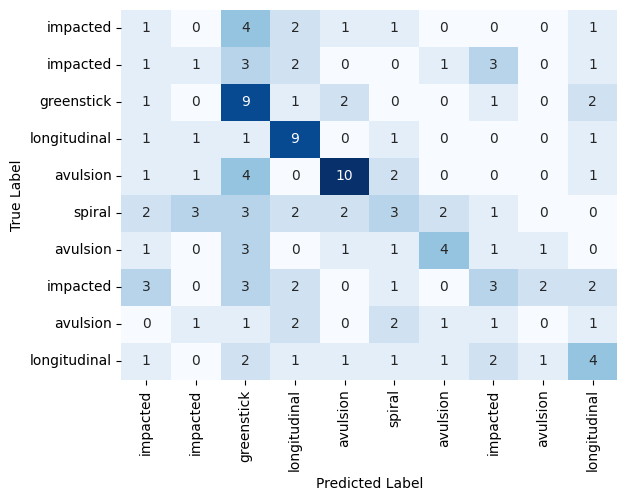

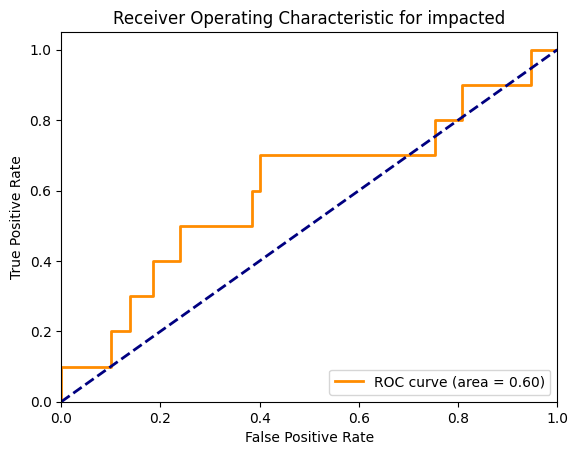

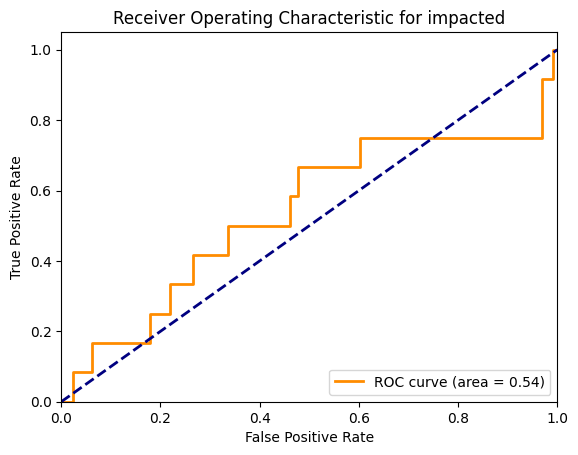

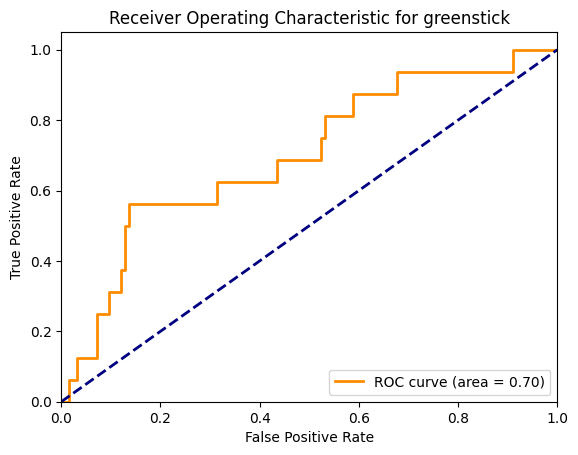

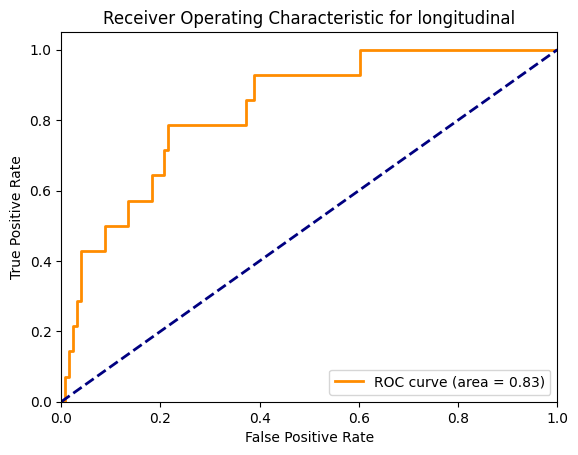

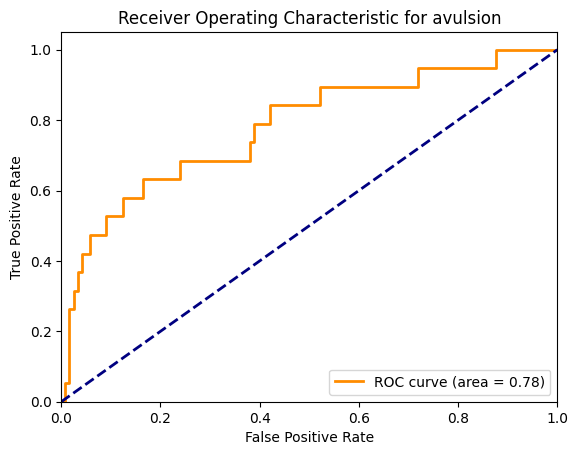

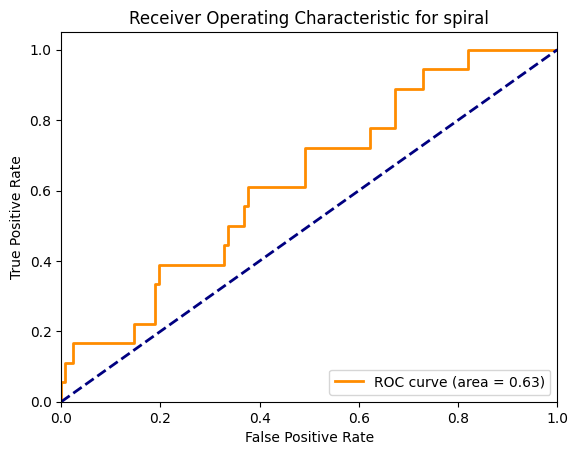

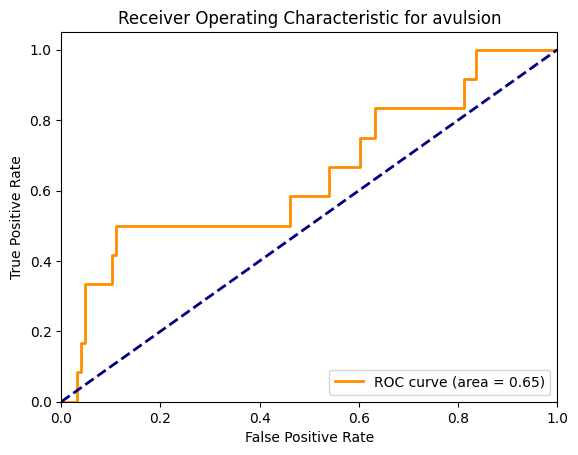

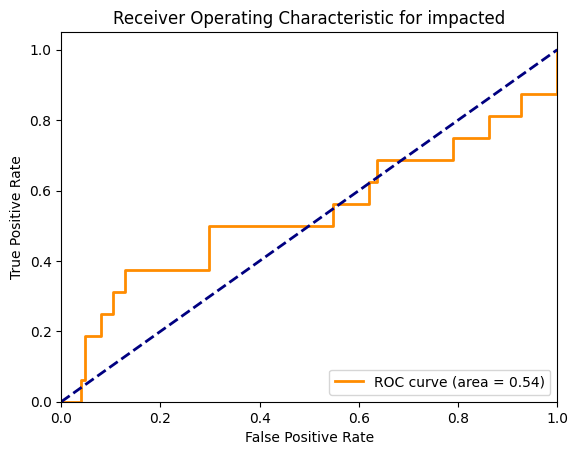

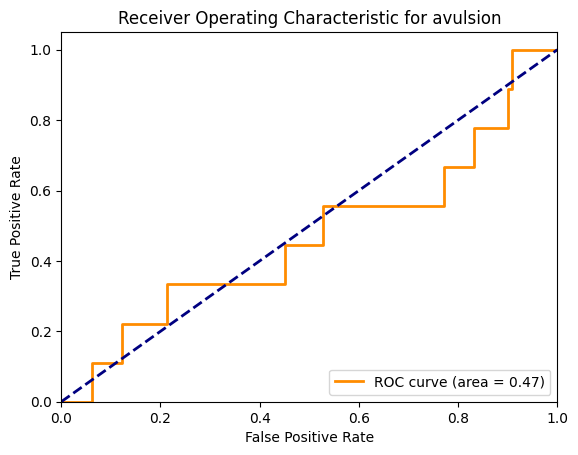

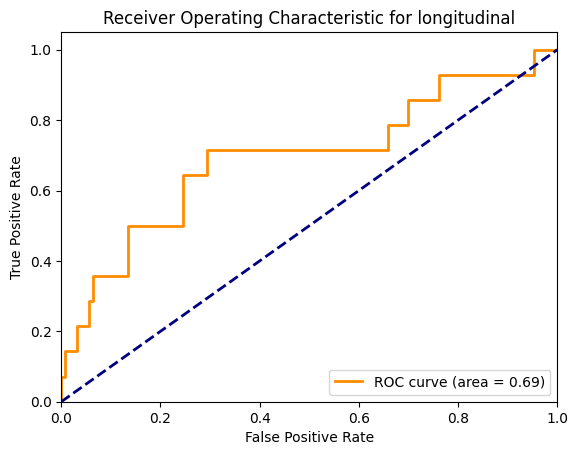

Accuracy: 0.3142857142857143
Classification Report:


,precision,recall,f1-score,support
impacted,0.083333,0.100000,0.090909,10.000000
impacted,0.142857,0.083333,0.105263,12.000000
greenstick,0.272727,0.562500,0.367347,16.000000
longitudinal,0.428571,0.642857,0.514286,14.000000
avulsion,0.588235,0.526316,0.555556,19.000000
spiral,0.250000,0.166667,0.200000,18.000000
avulsion,0.444444,0.333333,0.380952,12.000000
impacted,0.250000,0.187500,0.214286,16.000000
avulsion,0.000000,0.000000,0.000000,9.000000
longitudinal,0.307692,0.285714,0.296296,14.000000


In [7]:
y_pred = model.predict(images_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(images_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 2: HOG Feature Only

In [8]:
model = SVC(max_iter=1000, kernel='linear', probability=True)
model.fit(hog_train, y_train)


SVC(kernel='linear', max_iter=1000, probability=True)

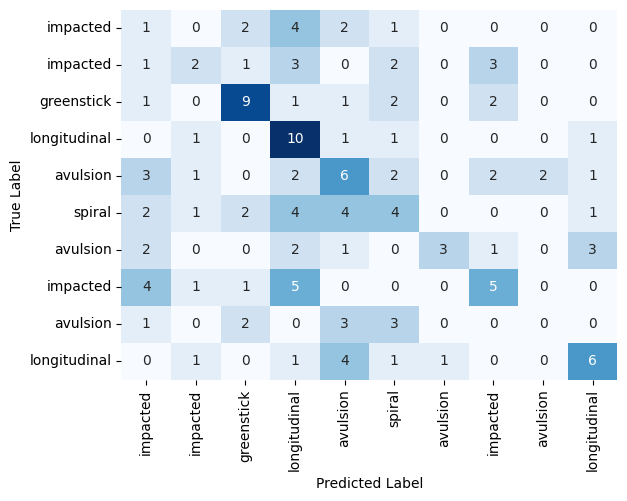

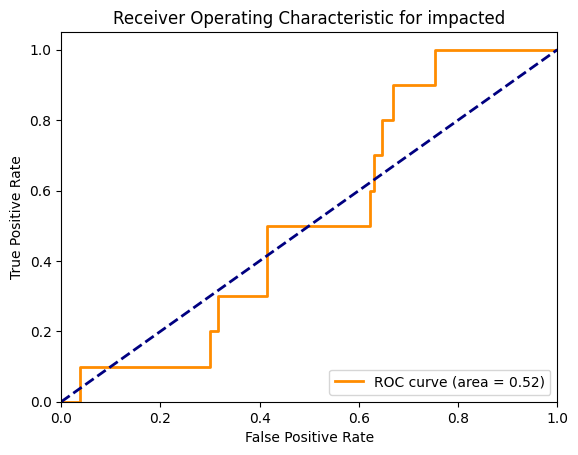

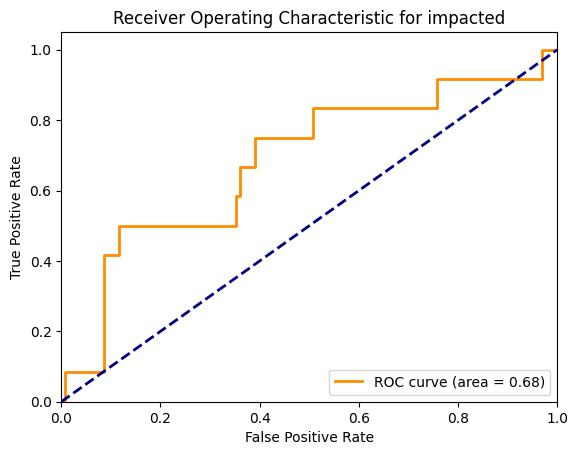

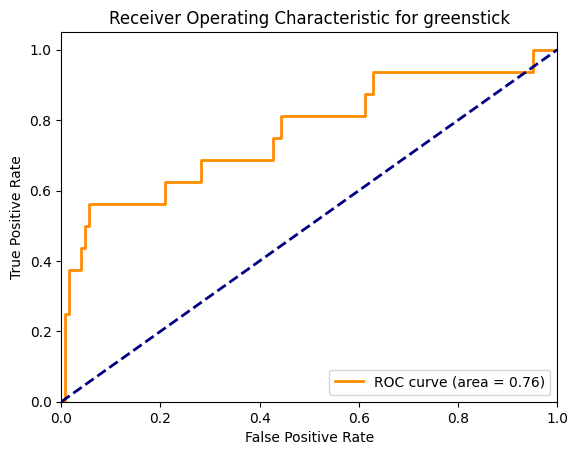

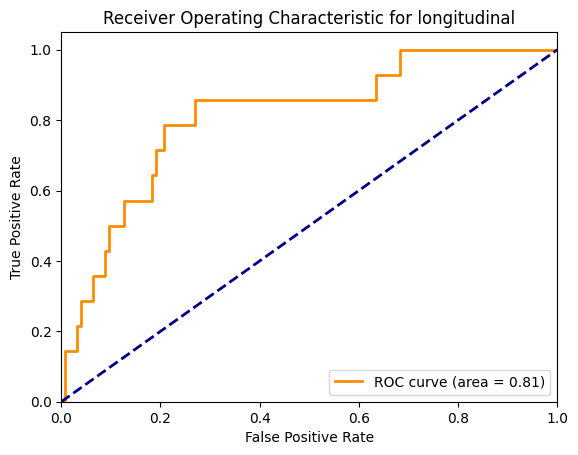

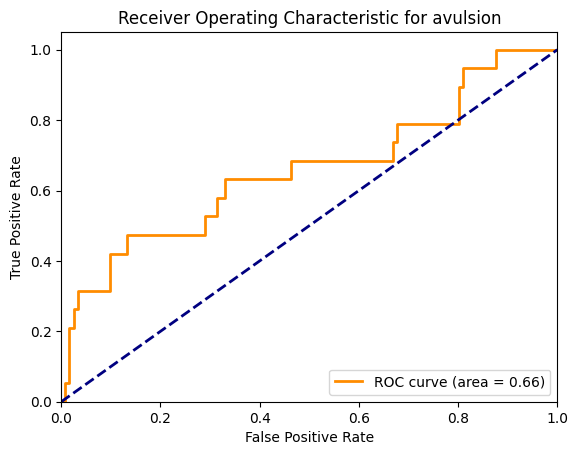

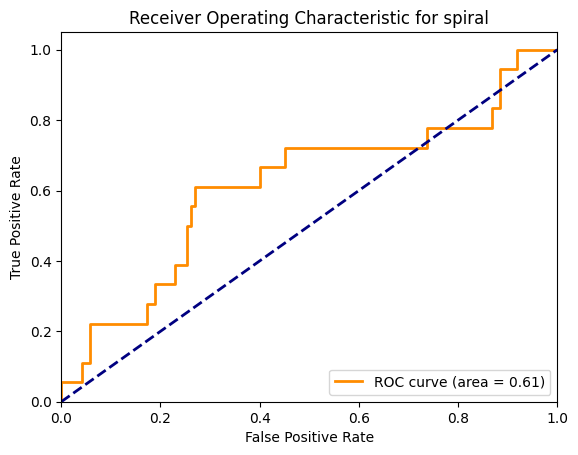

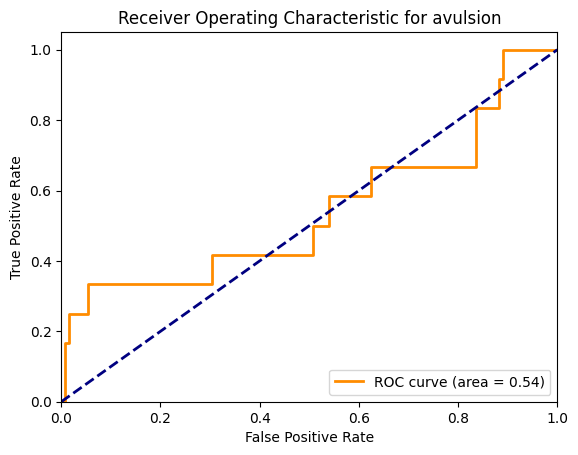

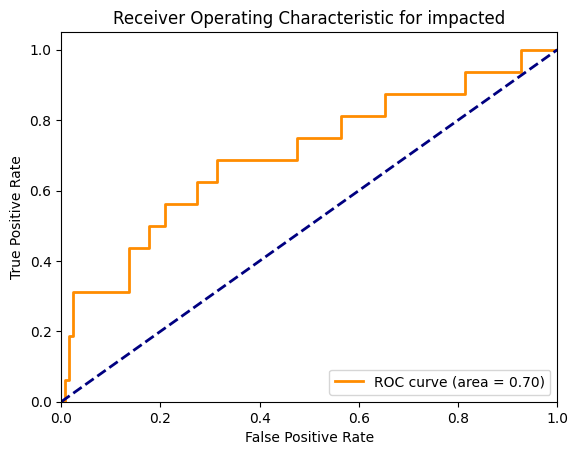

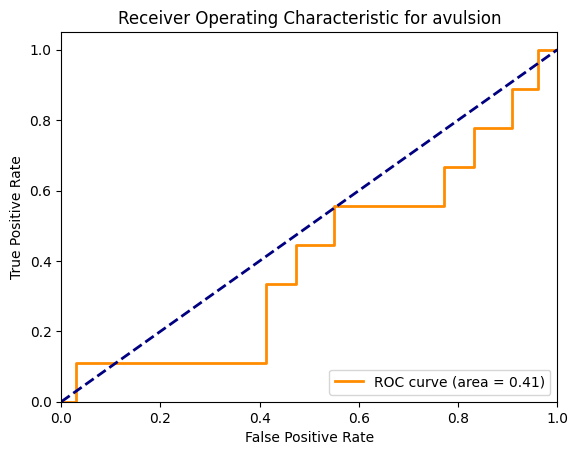

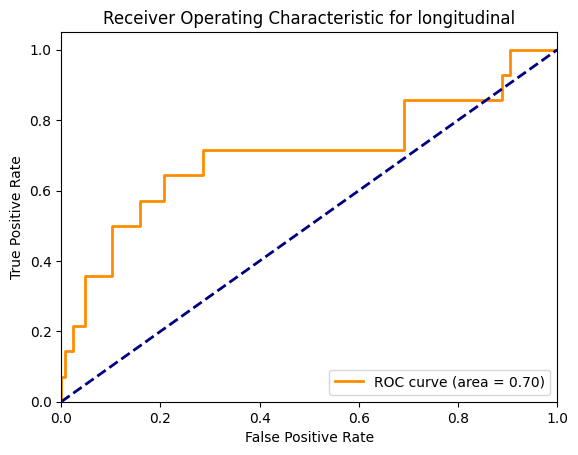

Accuracy: 0.32857142857142857
Classification Report:


,precision,recall,f1-score,support
impacted,0.066667,0.100000,0.080000,10.000000
impacted,0.285714,0.166667,0.210526,12.000000
greenstick,0.529412,0.562500,0.545455,16.000000
longitudinal,0.312500,0.714286,0.434783,14.000000
avulsion,0.272727,0.315789,0.292683,19.000000
spiral,0.250000,0.222222,0.235294,18.000000
avulsion,0.750000,0.250000,0.375000,12.000000
impacted,0.384615,0.312500,0.344828,16.000000
avulsion,0.000000,0.000000,0.000000,9.000000
longitudinal,0.500000,0.428571,0.461538,14.000000


In [9]:
y_pred = model.predict(hog_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(hog_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 3: Canny Edges Feature Only

In [10]:
model = SVC(max_iter=1000, kernel='linear', probability=True)
model.fit(canny_edges_train, y_train)


SVC(kernel='linear', max_iter=1000, probability=True)

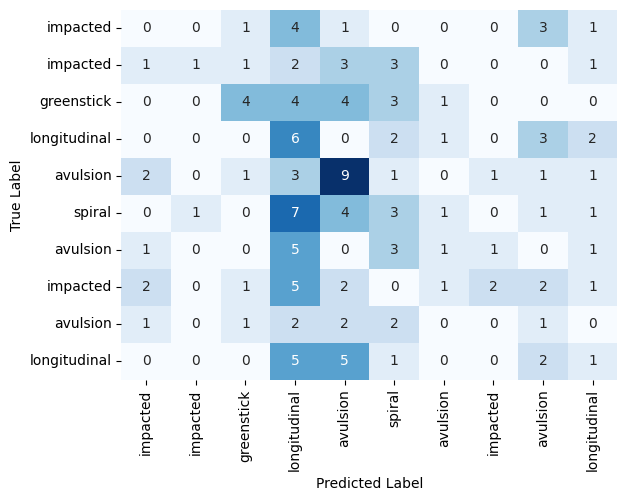

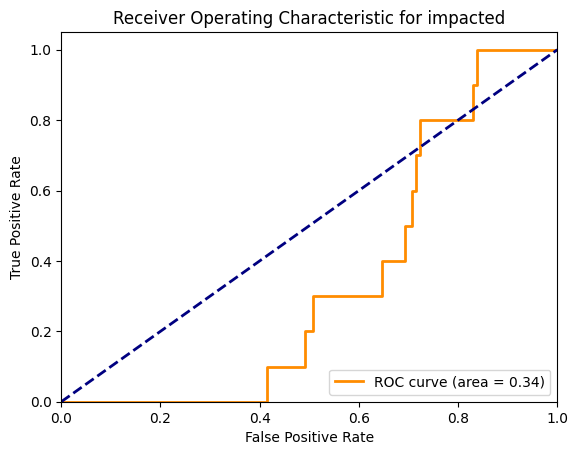

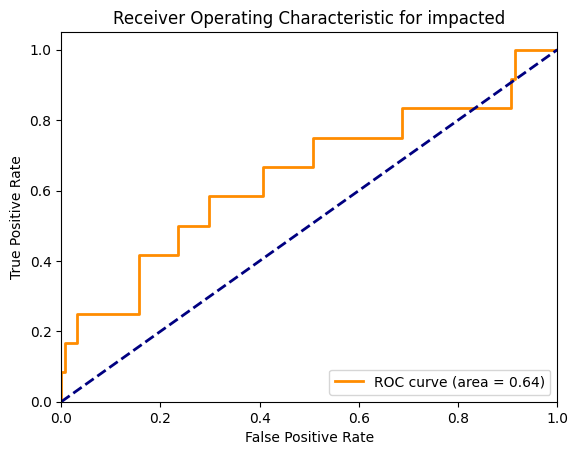

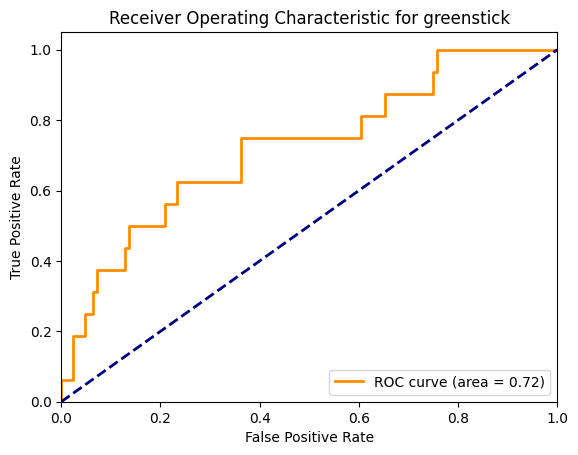

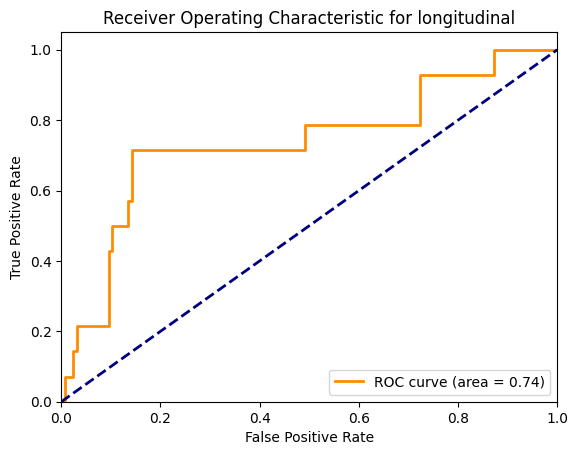

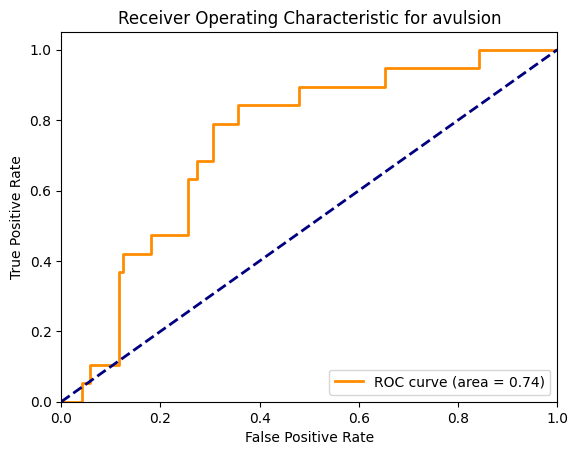

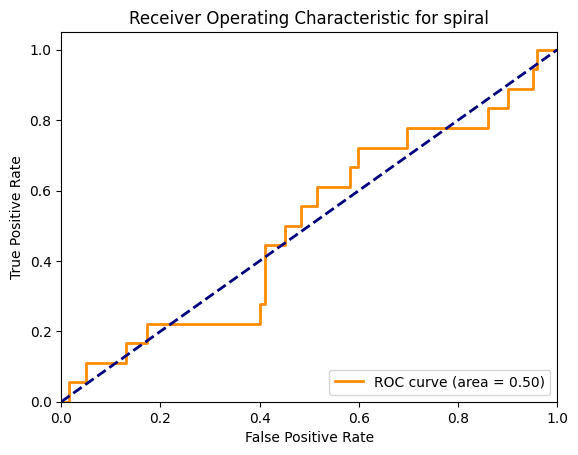

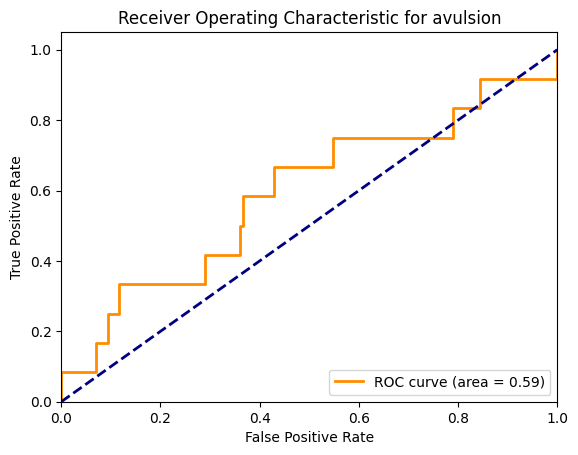

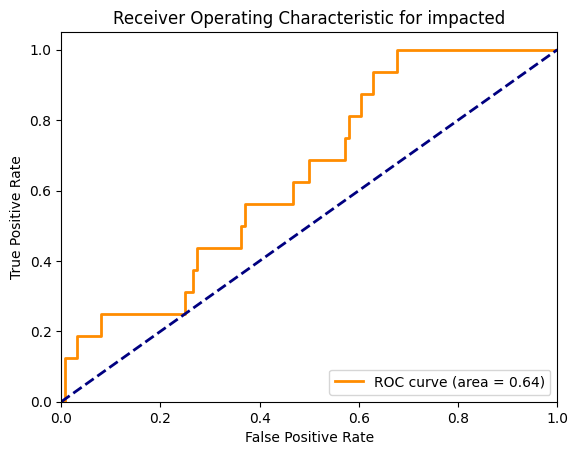

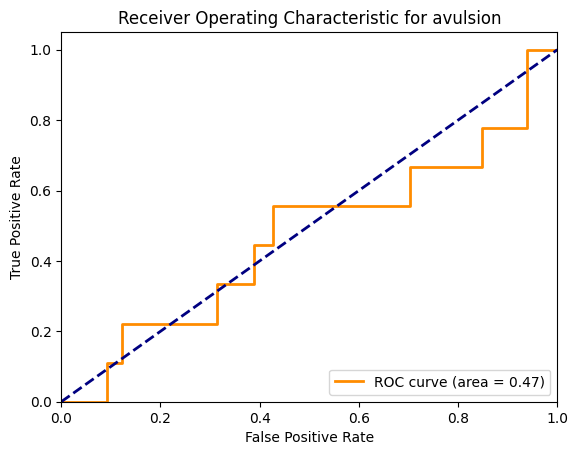

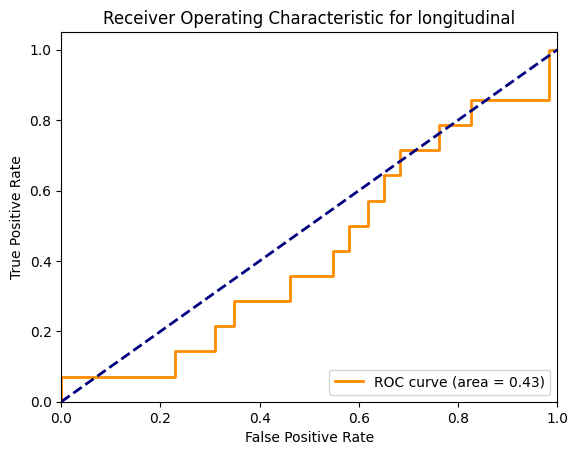

Accuracy: 0.2
Classification Report:


,precision,recall,f1-score,support
impacted,0.000000,0.000000,0.000000,10.0
impacted,0.500000,0.083333,0.142857,12.0
greenstick,0.444444,0.250000,0.320000,16.0
longitudinal,0.139535,0.428571,0.210526,14.0
avulsion,0.300000,0.473684,0.367347,19.0
spiral,0.166667,0.166667,0.166667,18.0
avulsion,0.200000,0.083333,0.117647,12.0
impacted,0.500000,0.125000,0.200000,16.0
avulsion,0.076923,0.111111,0.090909,9.0
longitudinal,0.111111,0.071429,0.086957,14.0


In [11]:
y_pred = model.predict(canny_edges_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(canny_edges_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 4: Contours Feature Only

In [12]:
model = SVC(max_iter=1000, kernel='linear', probability=True)
model.fit(contours_train, y_train)


SVC(kernel='linear', max_iter=1000, probability=True)

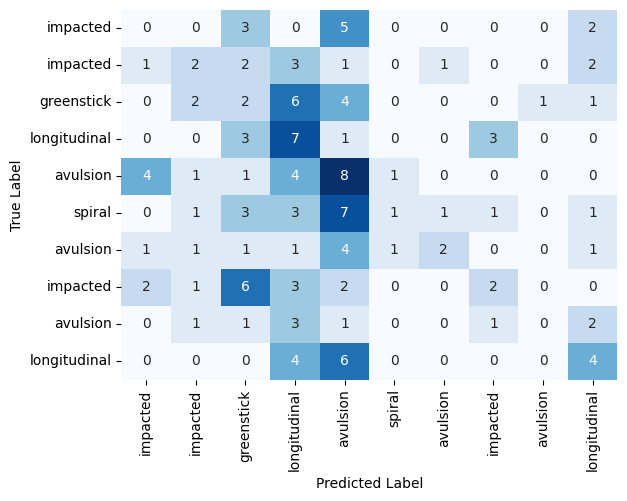

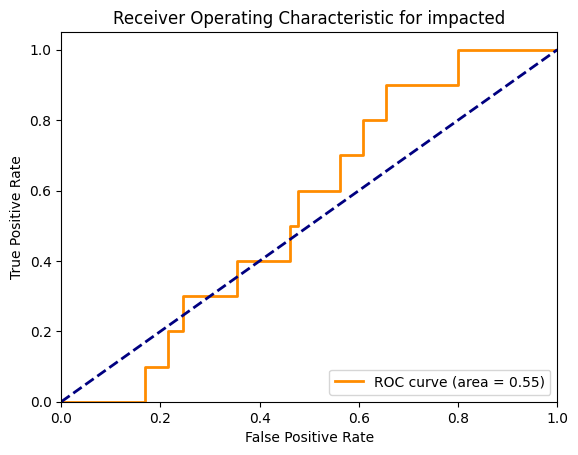

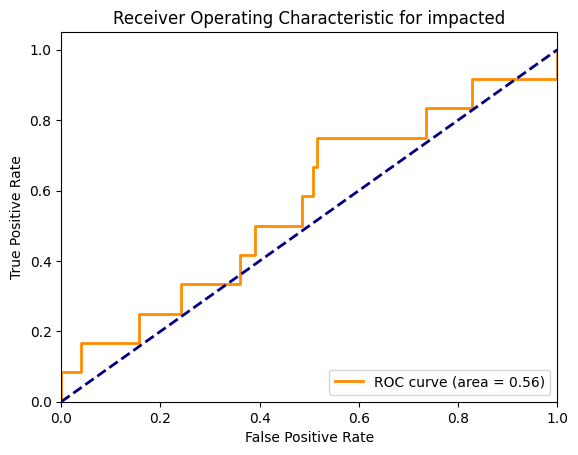

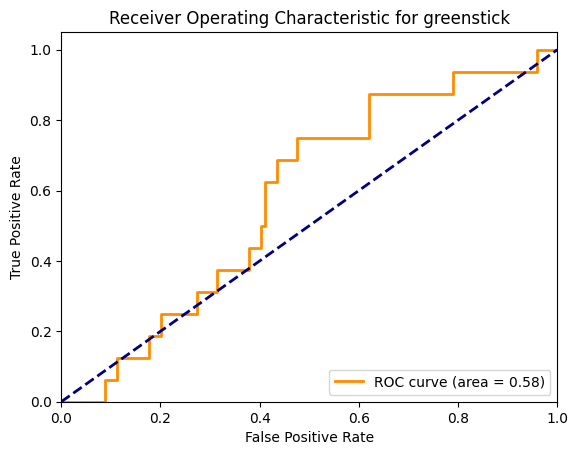

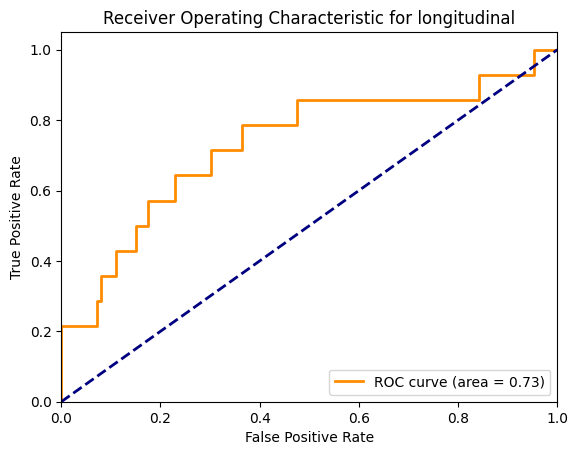

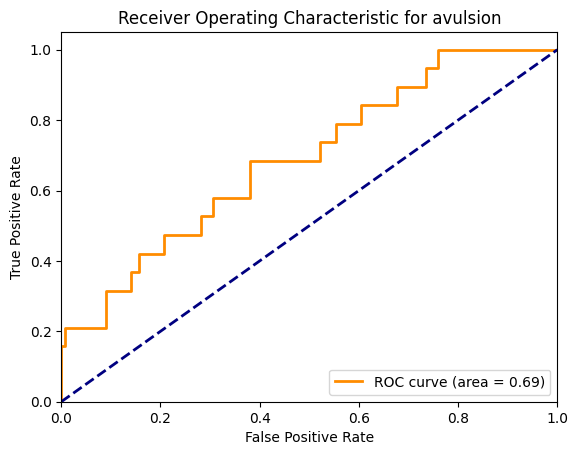

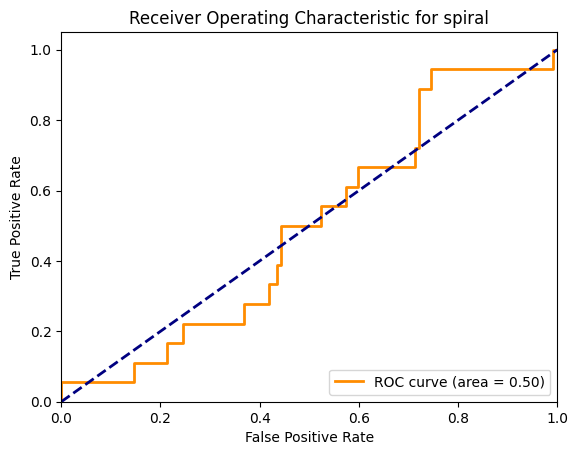

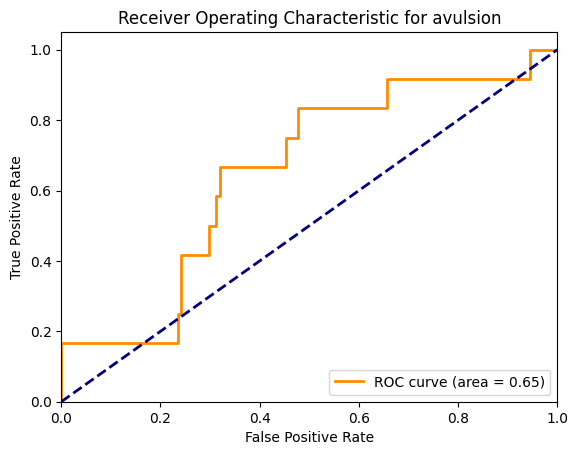

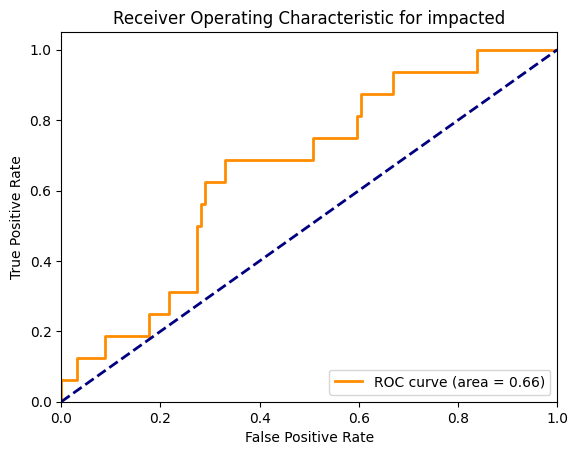

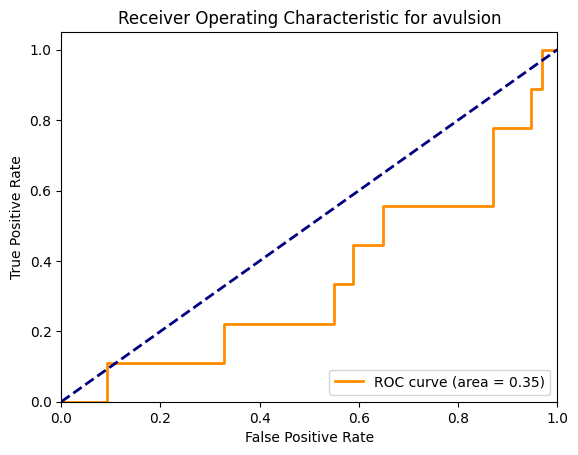

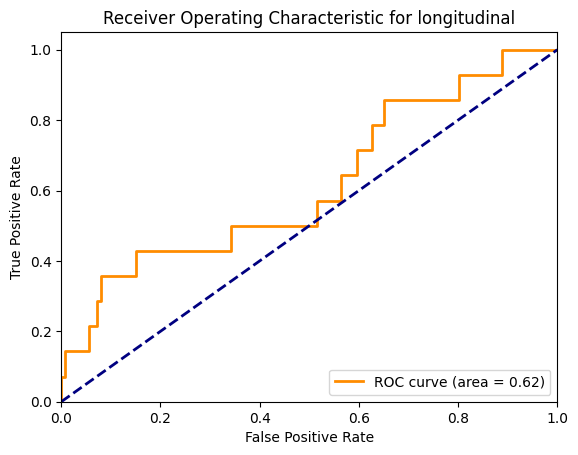

Accuracy: 0.2
Classification Report:


,precision,recall,f1-score,support
impacted,0.000000,0.000000,0.000000,10.0
impacted,0.222222,0.166667,0.190476,12.0
greenstick,0.090909,0.125000,0.105263,16.0
longitudinal,0.205882,0.500000,0.291667,14.0
avulsion,0.205128,0.421053,0.275862,19.0
spiral,0.333333,0.055556,0.095238,18.0
avulsion,0.500000,0.166667,0.250000,12.0
impacted,0.285714,0.125000,0.173913,16.0
avulsion,0.000000,0.000000,0.000000,9.0
longitudinal,0.307692,0.285714,0.296296,14.0


In [13]:
y_pred = model.predict(contours_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(contours_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 5: ImageNet Feature Only

In [14]:
model = SVC(max_iter=1000, kernel='linear', probability=True)
model.fit(imagenet_train, y_train)


SVC(kernel='linear', max_iter=1000, probability=True)

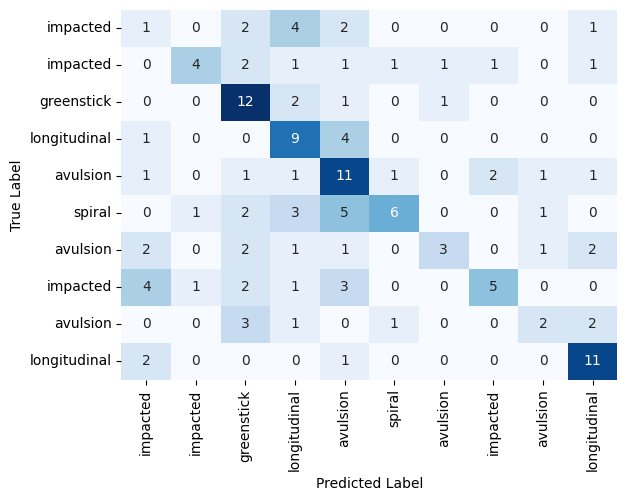

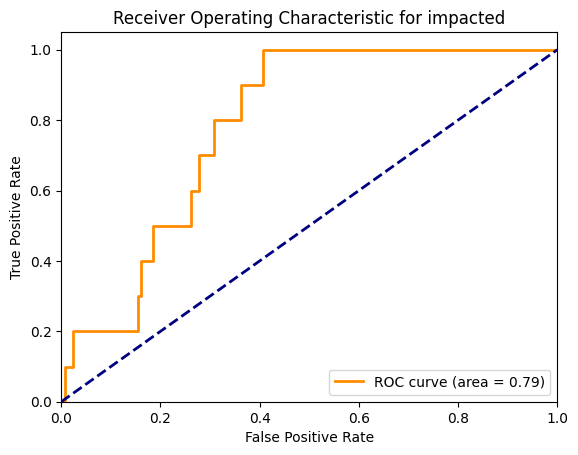

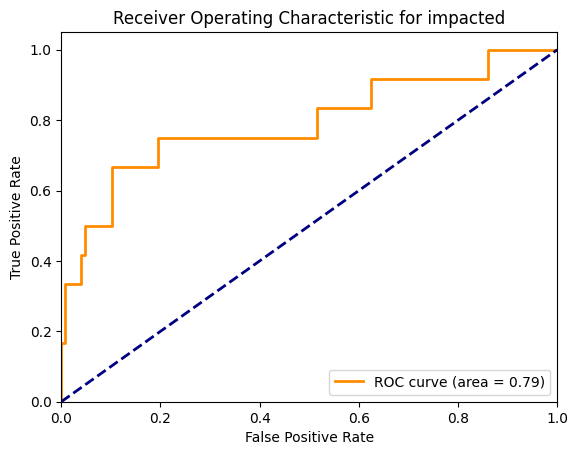

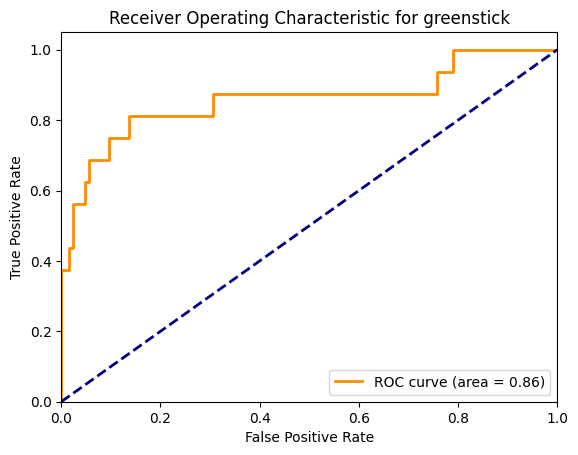

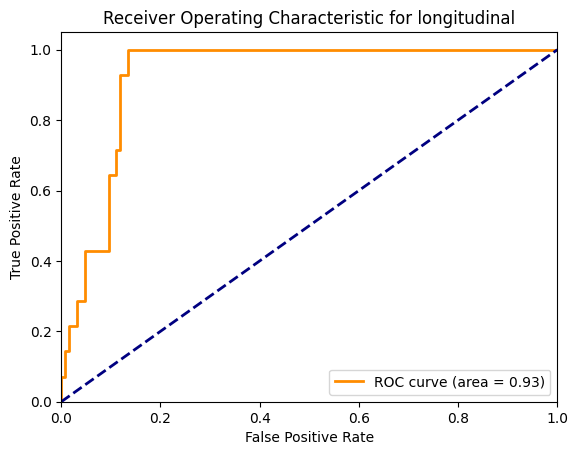

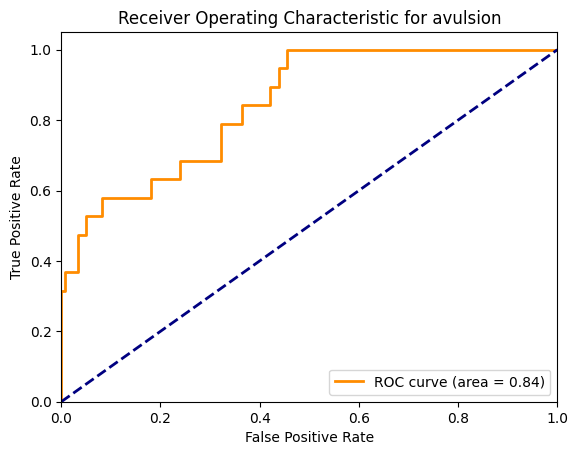

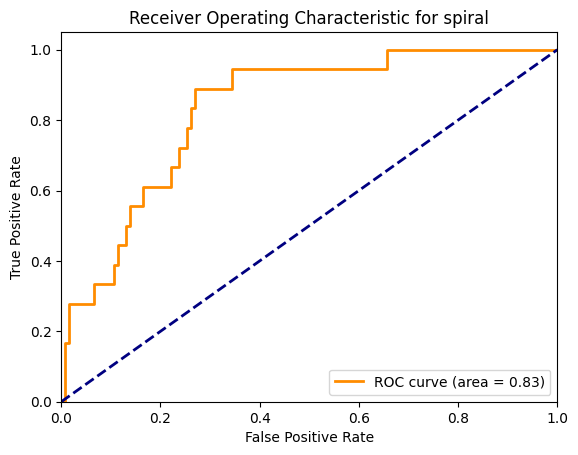

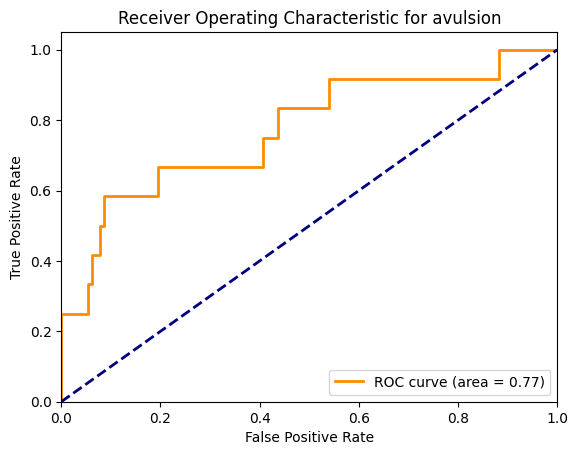

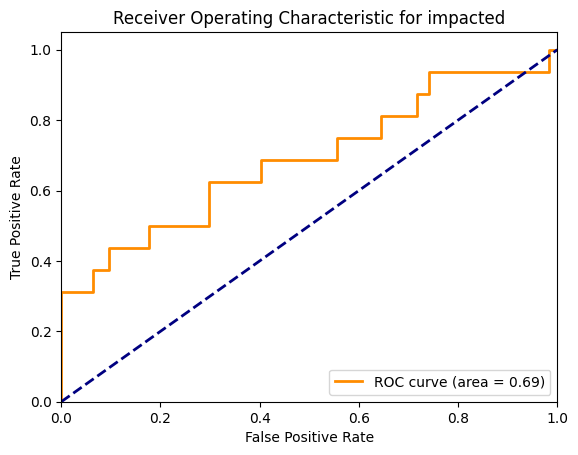

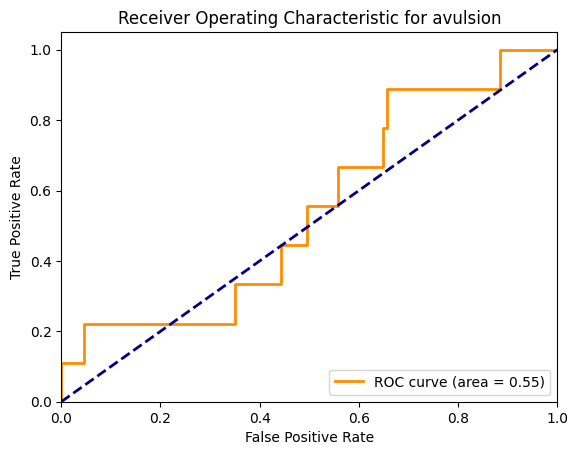

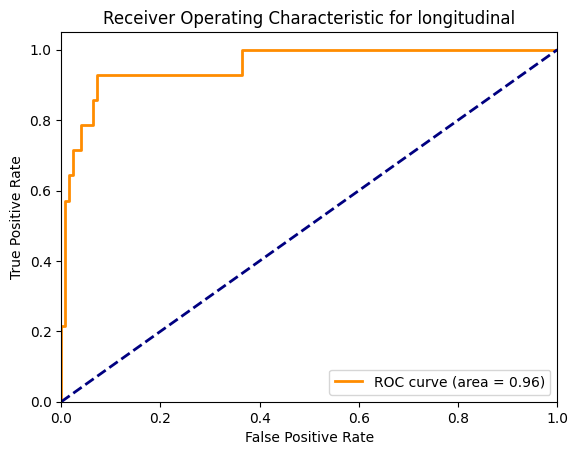

Accuracy: 0.45714285714285713
Classification Report:


,precision,recall,f1-score,support
impacted,0.090909,0.100000,0.095238,10.000000
impacted,0.666667,0.333333,0.444444,12.000000
greenstick,0.461538,0.750000,0.571429,16.000000
longitudinal,0.391304,0.642857,0.486486,14.000000
avulsion,0.379310,0.578947,0.458333,19.000000
spiral,0.666667,0.333333,0.444444,18.000000
avulsion,0.600000,0.250000,0.352941,12.000000
impacted,0.625000,0.312500,0.416667,16.000000
avulsion,0.400000,0.222222,0.285714,9.000000
longitudinal,0.611111,0.785714,0.687500,14.000000


In [15]:
y_pred = model.predict(imagenet_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(imagenet_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 6: PCA Feature Only

In [16]:
model = SVC(max_iter=1000, kernel='linear', probability=True)
model.fit(pca_train, y_train)


/home/davidsolow/.pyenv/versions/3.11.1/envs/fracture-classification/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=1000, probability=True)

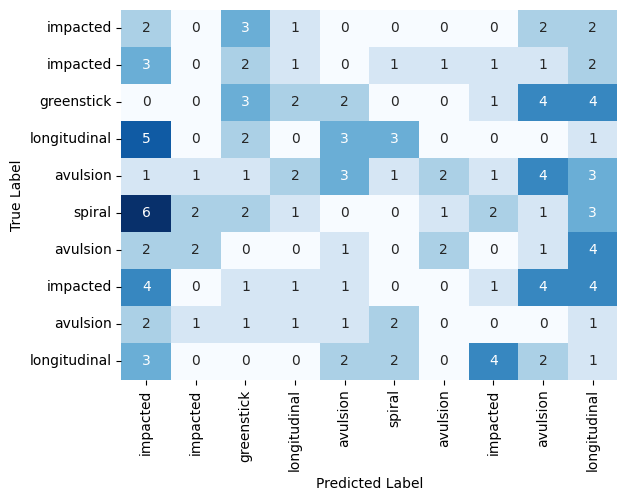

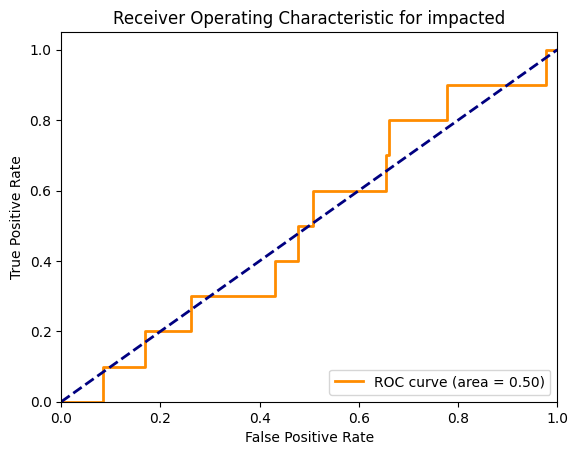

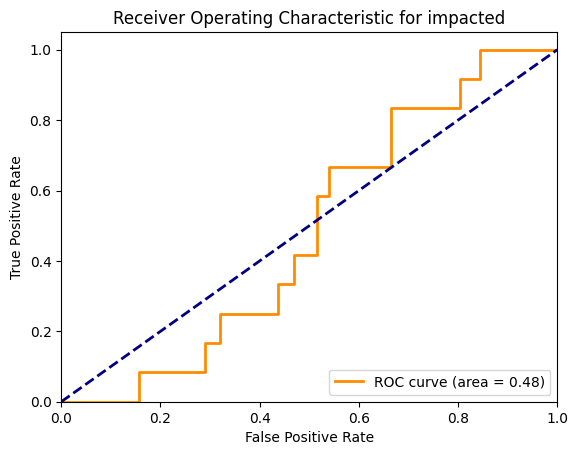

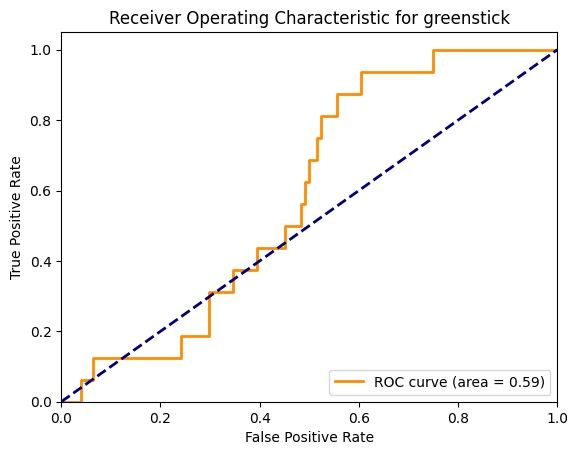

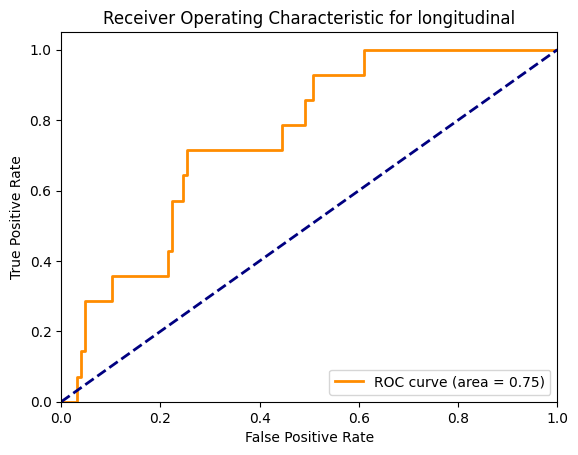

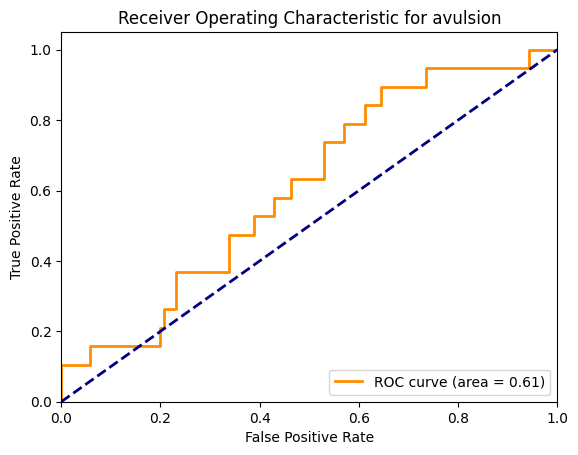

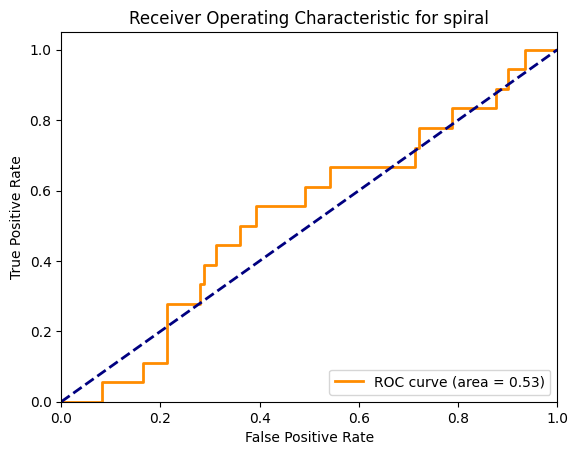

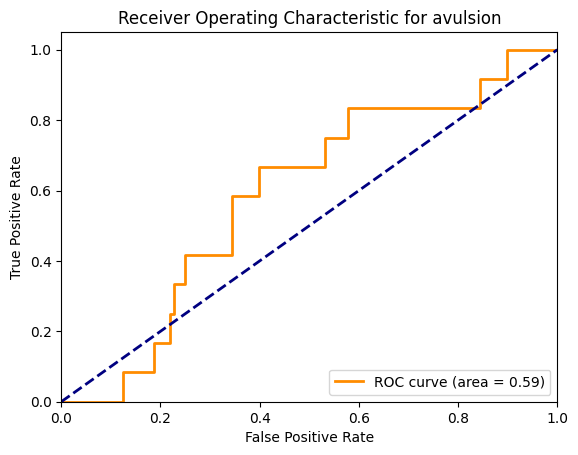

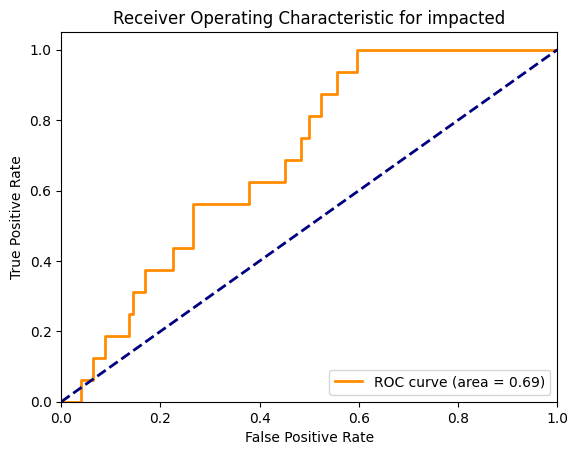

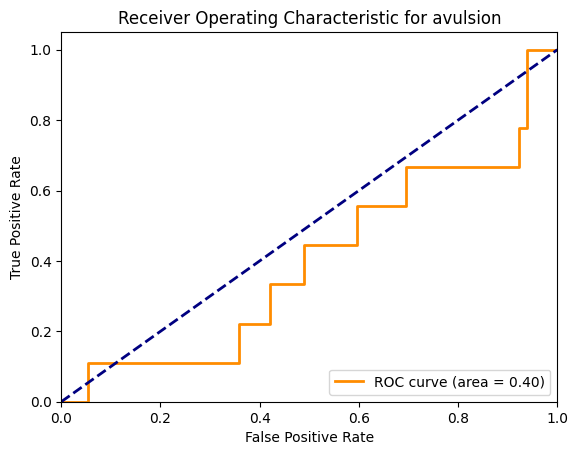

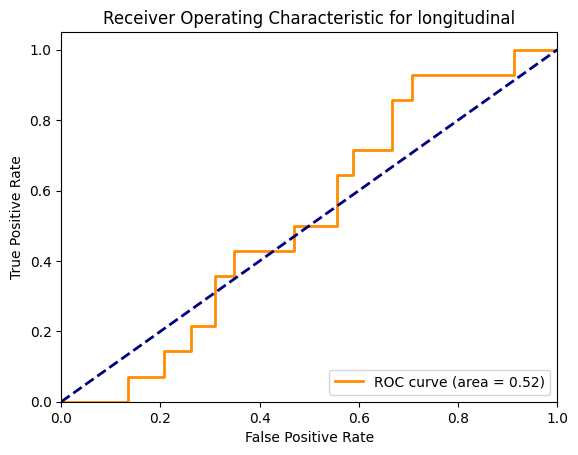

Accuracy: 0.08571428571428572
Classification Report:


,precision,recall,f1-score,support
impacted,0.071429,0.200000,0.105263,10.000000
impacted,0.000000,0.000000,0.000000,12.000000
greenstick,0.200000,0.187500,0.193548,16.000000
longitudinal,0.000000,0.000000,0.000000,14.000000
avulsion,0.230769,0.157895,0.187500,19.000000
spiral,0.000000,0.000000,0.000000,18.000000
avulsion,0.333333,0.166667,0.222222,12.000000
impacted,0.100000,0.062500,0.076923,16.000000
avulsion,0.000000,0.000000,0.000000,9.000000
longitudinal,0.040000,0.071429,0.051282,14.000000


In [17]:
y_pred = model.predict(pca_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(pca_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report

## Model 7: Best Combination

In [18]:
X_train = np.hstack((images_train, hog_train))
X_test = np.hstack((images_test, hog_test))

In [19]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC(max_iter=10000, probability=True)
rand_search = RandomizedSearchCV(estimator=svm,  param_distributions=param_grid_svm, n_iter=3, cv=3, n_jobs=-1, scoring='accuracy', random_state=42)
start_time = time.time()
rand_search.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

In [ ]:
model = rand_search.best_estimator_
start_time = time.time()
y_pred = model.predict(X_test)
inference_time = time.time() - start_time
print(f"Inference time: {inference_time:.2f} seconds")

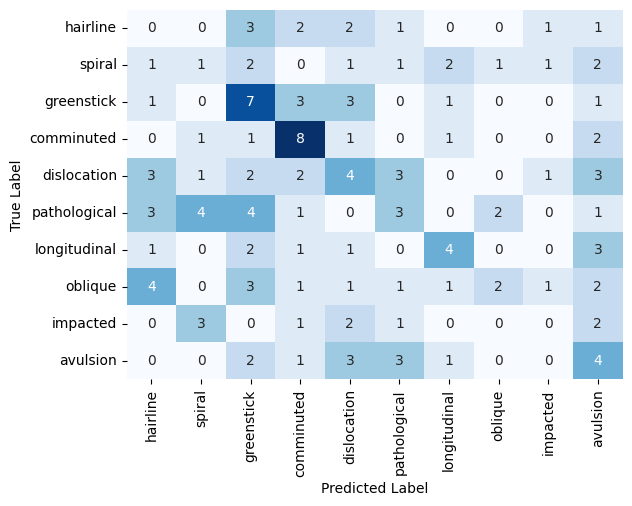

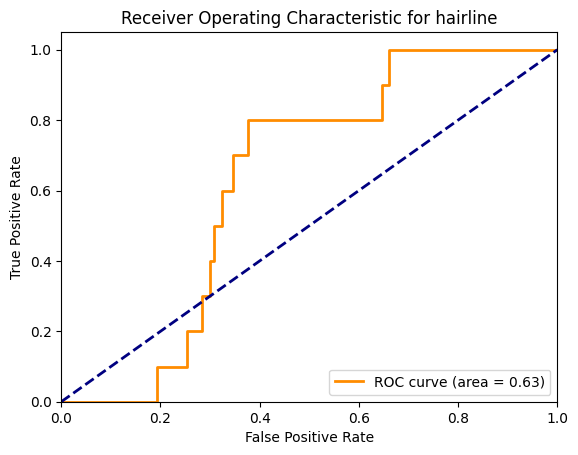

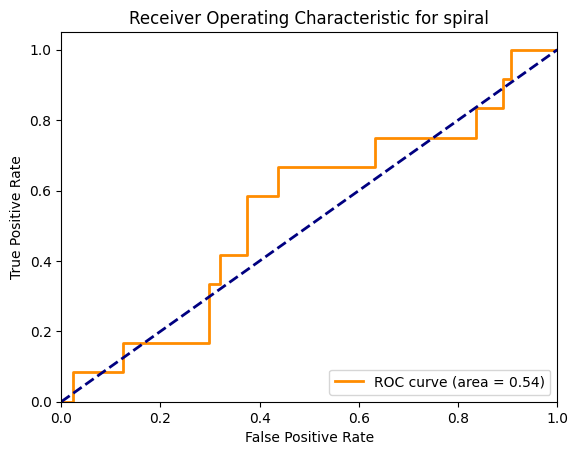

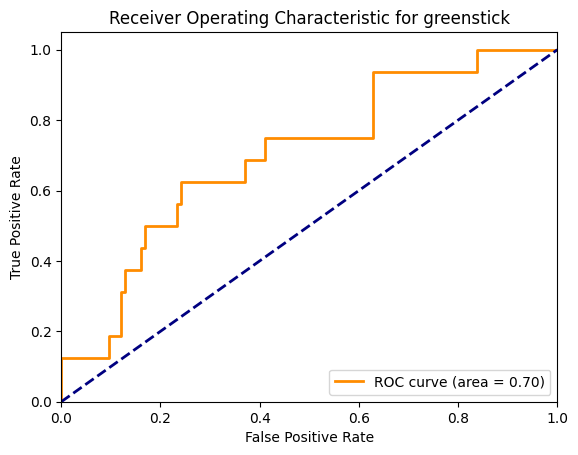

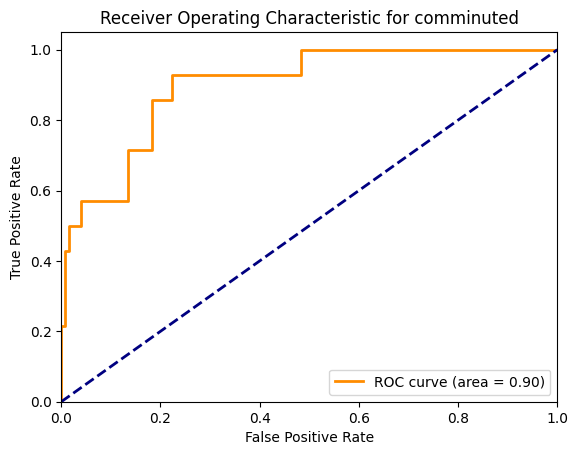

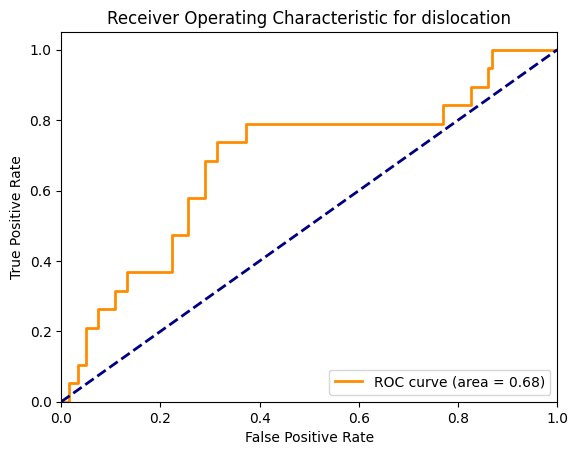

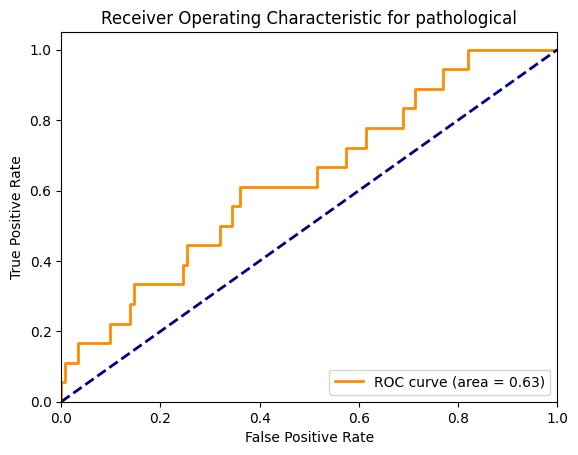

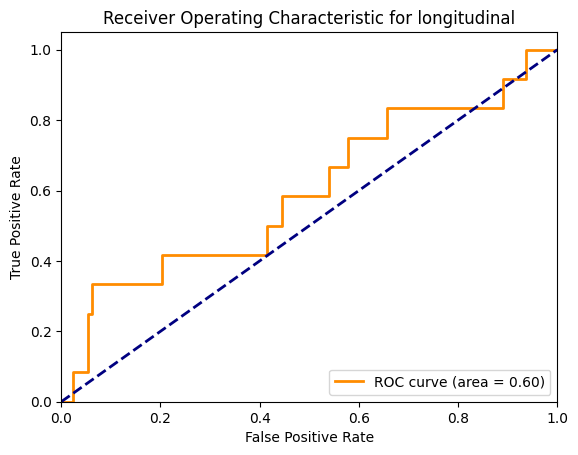

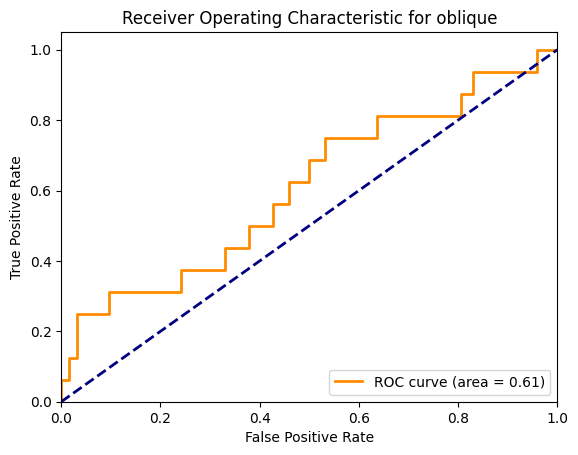

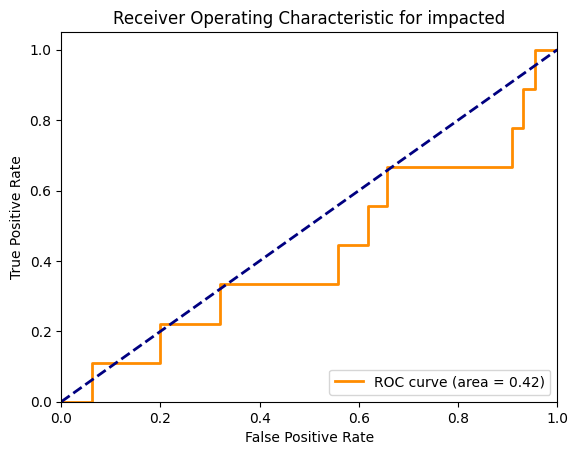

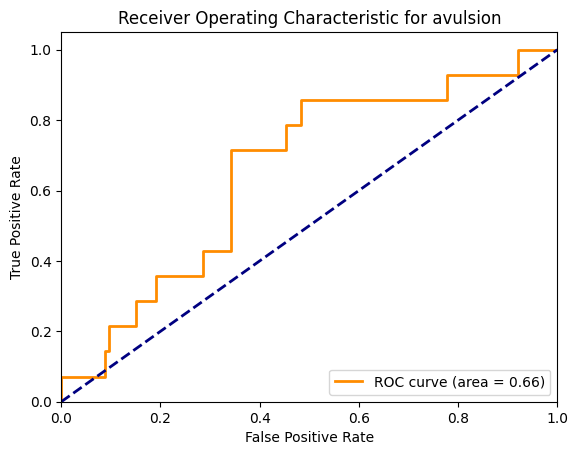

Accuracy: 0.2357142857142857
Classification Report:


,precision,recall,f1-score,support
hairline,0.000000,0.000000,0.000000,10.000000
spiral,0.100000,0.083333,0.090909,12.000000
greenstick,0.269231,0.437500,0.333333,16.000000
comminuted,0.400000,0.571429,0.470588,14.000000
dislocation,0.222222,0.210526,0.216216,19.000000
pathological,0.230769,0.166667,0.193548,18.000000
longitudinal,0.400000,0.333333,0.363636,12.000000
oblique,0.400000,0.125000,0.190476,16.000000
impacted,0.000000,0.000000,0.000000,9.000000
avulsion,0.190476,0.285714,0.228571,14.000000


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report.index = report.index.map(lambda x: class_lookup[int(x)] if x.isdigit() else x)

test_confusion_matrix = confusion_matrix(y_test, y_pred)
show_confusion_matrix(test_confusion_matrix)

y_score = model.predict_proba(X_test)
show_roc_curve(y_score, y_test)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
report